# WaterTAP — Crystallizer Technology Screening 

## Section A: Crystallizer with Forced Circulation (FC) heated by steam
<!-- # WaterTAP — Steam-Driven Crystallizer (Industry Demo)
section A: Digital twin of a forced-circulation crystallizer heated by steam: properties → equipment → connections → costing → operating → simulate baseline → optimize → KPIs. -->


<p align="center">
    <img src="fc.png" alt="Breakthrough Curve" width="400"/>
</p>

## Step 1: Import Model Flowsheet

In [23]:
import logging, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import idaes.logger as idaeslog
from IPython.display import clear_output

for _n in (
    "idaes",
    "idaes.core.util.scaling",
    "idaes.core.base.property_meta",
    "pyomo",
    "watertap",
):
    try:
        idaeslog.getLogger(_n).setLevel(idaeslog.CRITICAL)
    except Exception:
        logging.getLogger(_n).setLevel(logging.CRITICAL)
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")

# core imports
# import crystallizer_live_steam_with_condenser_chiller as steam
from pyomo.environ import (
    Objective,
    Constraint,
    value,
)
from idaes.core.util.model_statistics import degrees_of_freedom
from watertap.flowsheets.crystallization import (
    crystallizer_live_steam_with_condenser_chiller as steam,
)
from watertap.core.solvers import get_solver
from watertap.core.util.model_diagnostics.infeasible import (
    print_infeasible_constraints,
    print_variables_close_to_bounds,
)
from demo_utils import kpis_mass_energy, plot_contour, plot_min_lcow


print("✅ Module imported")

✅ Module imported


## Step 2: Build the Flowsheet
1. **Add Thermophysical Property Models:** 
    * brine (NaCl–H₂O) for the feed, mixed recycle, and purge streams
    * water/steam for vapor/condensate
    * crystallizer salt package for **enthalpy** and **phase equilibrium/solubility** to represent supersaturation and crystal formation.  
2. **Add Unit Models (equipment):** 
    * **Feed**: define inlet properties
    * **Mixer**: blend with recycle stream
    * **Pump**: for forced circulation
    * **Steam Heater**: steam on hot-side, brine on cold-side
    * **Crystallizer**: crystal growth + vapor disengagement
    * **Condenser + Chiller** (recover water and close the cold loop), **Separator** (split slurry into recycle + purge), **Product** (distillate).  
3. **Add Connections:** 
    * pipe unit ports in process order
    * route vapor to condenser
    * return condenser cold outlet via chiller
    * create recycle and purge branches
4. **Add Practical Constraints:**  
    * **Max temperature rise across the liquor in the heater** to moderate supersaturation rate, avoid wall-scale/flash boiling, and protect the exchanger—typically **~3–6 K** (site-tuned).  
    * **ΔTmin check** (steam–liquor approach) for heat-exchanger design sanity.
    * **purge stream:** a small, controlled branch removes concentrated liquor/solids to keep the loop inside scaling limits and keep product quality steady—just like FC circuits in the field.  
6. **Add Costing:**
    * cost blocks on key units so physics maps directly to **LCOW** and energy Key Process Indicators (KPIs).


In [24]:
# Build (logs suppressed)/
m = steam.build()
print("✅ Flowsheet built")

✅ Flowsheet built


## Step 3: Set Operating Conditions

* Flow rate = 1 MGD
* Salinity = 250 g/L
* Pump ΔP for circulation
* Crystallizer operating temperature
* Steam-side conditions

In [25]:
steam.set_operating_conditions(m)
print("✅ Operating conditions applied")

DOF final: 0
✅ Operating conditions applied


## Step 4: Initialize Flowsheet 
### Steady-state startup sequence, fully-specified 0 DOF

Bring units online in process order and align states across connections so the flowsheet starts from a stable, plant-sensible point before solving.

In [26]:
m.fs.feed.properties[0].conc_mass_phase_comp
m.fs.feed.properties[0].flow_vol_phase
steam.initialize_system(m)
# m.fs.feed.properties.display()
clear_output(wait=False)
print("✅ Initialization complete")
print(f"DOF = {degrees_of_freedom(m)}")

# print(f"LCOW = {value(m.fs.costing.LCOW):.4f} $/m3")

✅ Initialization complete
DOF = 0


## Step 5: Setup Optimization (steady state, with bounds)

### Promote selected operating variables to **decisions** and apply **bounds** (e.g., heater outlet-temperature band, circulation targets).  

This remains a steady-state problem but opens degrees of freedom to seek **best achievable cost/energy** under practical limits.

In [27]:
# steam.optimize_set_up(m)\
# Add objective to minimize LCOW
m.fs.objective = Objective(expr=m.fs.costing.LCOW, sense="minimize")

# Unfix heater cold side outlet temperature
# and set practical lower and upper bounds
m.fs.heater.cold_side_outlet.temperature.unfix()
m.fs.heater.cold_side_outlet.temperature.setlb(273.15 + 50)
m.fs.heater.cold_side_outlet.temperature.setub(273.15 + 70)

# Set lower bound for recycle stream mass flow rate
m.fs.mixer.recycle.flow_mass_phase_comp[0, "Liq", "H2O"].lb = 300
m.fs.mixer.recycle.flow_mass_phase_comp[0, "Liq", "H2O"].set_value(400)
m.fs.heater.area.setlb(100)

print("✅ Optimization set up complete")
print("Before optimization:")
print(
    f"Heater Cold Side Outlet Temperature = {value(m.fs.heater.cold_side_outlet.temperature[0]):.2f} K"
)
print(f"DOF = {degrees_of_freedom(m)}")

✅ Optimization set up complete
Before optimization:
Heater Cold Side Outlet Temperature = 327.15 K
DOF = 1


## Step 6: Optimize for Steady-State Operation
Solve the bounded, steady-state optimization to find an economical/energy-efficient operating point within plant-sensible limits.

In [28]:
results = steam.solve(m)
clear_output(wait=False)
# m.fs.costing.LCOW.display()
# m.fs.heater.cold_side_outlet.temperature.display()
print("✅ Optimization solved")
print("After optimization:")
print(
    f"Heater Cold Side Outlet Temperature = {value(m.fs.heater.cold_side_outlet.temperature[0]):.2f} K"
)

✅ Optimization solved
After optimization:
Heater Cold Side Outlet Temperature = 323.15 K


## Step 8: Report KPIs (unit-labeled, plant-relevant)
• **Feed (kg/s)** — incoming mass rate to the loop  
• **Distillate (kg/s)** — clean water produced  
• **Solids NaCl (kg/s)** — crystal production rate  
• **Steam (kg/s)** — motive steam to the heater  
• **Heat duty (MW)** — steam-side duty at the heater  
• **Heater area (m²)** — exchanger size implication  
• **LCOW ($/m³)** — levelized cost signal for decision-making

In [29]:
kpi_table = kpis_mass_energy(m)
# kpi_table.style.format(
#     {
#         "Feed (kg/s)": "{:.3f}",
#         "Distillate (kg/s)": "{:.3f}",
#         "Solids NaCl (kg/s)": "{:.3f}",
#         "Steam (kg/s)": "{:.3f}",
#         "Heat duty (MW)": "{:.3f}",
#         "Heater area (m²)": "{:.2f}",
#         "LCOW ($/m³)": "{:.2f}",
#         "CAPEX ($M)": "{:.2f}",
#         "OPEX ($M/yr)": "{:.2f}",
#         "Total Power Required (MW)": "{:.2e}"
#     }
# )
for col in kpi_table.columns:
    print(f"{col:<20}: {kpi_table[col].iloc[0]:3f}")

Feed (kg/s)         : 49.444500
Distillate (kg/s)   : 15.689563
Solids NaCl (kg/s)  : 2.000000
Steam (kg/s)        : 18.141532
Heat duty (MW)      : -41.038625
Heater area (m²)    : 215.101316
LCOW ($/m³)         : 1.221665
SEC (kWh/m³)        : 5.859627
CAPEX ($M)          : 9.987300
OPEX ($M/yr)        : 0.483438


## Section B: Crystallizer with MVC (Mechanical Vapor reCompression)

<p align="center">
    <img src="mvc.png" alt="MVC" width="400"/>
</p>

### **Difference vs. steam-driven:**  
* **Add Compressor**
    * mechanically recompresses vapor instead of using more live steam
* **Condenser/Heat-exchange Loop**
    * returns latent heat to the brine stream and electricity becomes the primary energy driver
* **Connections**
    * crystallizer vapor directed to compressor and then back into the heater hot side
    * product water leaves the hot side of heater
* **Plant Intuition**
    * lower steam use, higher kWh
    * good where electricity is cheap or where steam availability is limited

In [30]:
import Crystallizer_MVR as mvc


m_mvc = mvc.build()
mvc.set_operating_conditions(m_mvc)
mvc.initialize_system(m_mvc)

# mvc.optimize_set_up(m_mvc)
print(f"DOF = {degrees_of_freedom(m_mvc)}")
m_mvc.fs.objective = Objective(expr=m_mvc.fs.costing.LCOW)

# Unfix compressor pressure ratio and set reasonable bounds
m_mvc.fs.compressor.pressure_ratio.unfix()
m_mvc.fs.compressor.pressure_ratio.setlb(1.2)
m_mvc.fs.compressor.pressure_ratio.setub(3)

# Constrain the heater temperature rise on cold side to <4C
m_mvc.fs.eq_heater_temperature_rise = Constraint(
    expr=m_mvc.fs.heater.cold_side_outlet.temperature[0]
    - m_mvc.fs.heater.cold_side_inlet.temperature[0]
    <= 4
)

# Unfix crystallizer inlet temperature and set reasonable bounds
m_mvc.fs.crystallizer.inlet.temperature.unfix()
m_mvc.fs.crystallizer.inlet.temperature.setlb(273.15 + 50)
m_mvc.fs.crystallizer.inlet.temperature.setub(273.15 + 110)

# Set lower bound for recycle stream mass flow rate
m_mvc.fs.mixer.recycle.flow_mass_phase_comp[0, "Liq", "H2O"].lb = 100
m_mvc.fs.mixer.recycle.flow_mass_phase_comp[0, "Liq", "H2O"].set_value(500)

clear_output(wait=False)
print(f"DOF = {degrees_of_freedom(m_mvc)}")
print("Before optimization:")
print(f"Compressor Pressure Ratio = {value(m_mvc.fs.compressor.pressure_ratio):.2f}")
print(
    f"Crystallizer Inlet Temperature = {value(m_mvc.fs.crystallizer.inlet.temperature[0]):.2f} K\n"
)

mvc.solve(m_mvc, tee=False)
# clear_output(wait=False)

print(f"DOF = {degrees_of_freedom(m_mvc)}")
print("After optimization:")
print(f"Compressor Pressure Ratio = {value(m_mvc.fs.compressor.pressure_ratio):.2f}")
print(
    f"Crystallizer Inlet Temperature = {value(m_mvc.fs.crystallizer.inlet.temperature[0]):.2f} K\n"
)
print("✅ MVC flowsheet solved")

print(f"\tLCOW FC w/ Steam = {value(m.fs.costing.LCOW):.4f} $/m3")
print(f"\tLCOW MVC = {value(m_mvc.fs.costing.LCOW):.4f} $/m3")

DOF = 2
Before optimization:
Compressor Pressure Ratio = 1.50
Crystallizer Inlet Temperature = 330.62 K

DOF = 2
After optimization:
Compressor Pressure Ratio = 1.20
Crystallizer Inlet Temperature = 323.15 K

✅ MVC flowsheet solved
	LCOW FC w/ Steam = 1.2217 $/m3
	LCOW MVC = 1.7864 $/m3


## Section C: Fast-Build TVC (Steam Ejector / Thermal Vapor Compression)

<p align="center">
    <img src="tvc.png" alt="TVC" width="400"/>
</p>


### **Difference vs. steam-driven:**  
* **Steam ejector (TVC)**
    * uses **motive steam** to draw and recompress vapor, reducing net external steam to the heater
* **Condenser/Heat-exchange Loop**
    * returns latent heat to the brine stream and electricity becomes the primary energy driver
* **Connections**
    * crystallizer vapor directed to steam ejector (plus motive steam) then to condenser loop and then back to heater
    * product water leaves from condenser 
* **Plant Intuition**
    * mid-ground between steam-only and MVC
    * still uses steam, but leverages ejector mixing to reduce overall duty


In [32]:
import crystallizer_TVC as tvc


m_tvc = tvc.build()
tvc.set_operating_conditions(m_tvc)
print(f"DOF = {degrees_of_freedom(m_tvc)}")
tvc.initialize_system(m_tvc)
clear_output(wait=False)
# tvc.optimize_set_up(m_tvc)

print(f"DOF = {degrees_of_freedom(m_tvc)}")
m_tvc.fs.objective = Objective(expr=m_tvc.fs.costing.LCOW)

# Unfix compressor pressure ratio and set reasonable bounds
m_tvc.fs.SteamEjector.compression_ratio.unfix()
m_tvc.fs.SteamEjector.compression_ratio.setlb(1.9)
m_tvc.fs.SteamEjector.compression_ratio.setub(2)

m_tvc.fs.heater.area.setlb(900)

# Unfix crystallizer inlet temperature and set reasonable bounds
m_tvc.fs.crystallizer.inlet.temperature.unfix()
m_tvc.fs.crystallizer.inlet.temperature.setlb(273.15 + 50)
m_tvc.fs.crystallizer.inlet.temperature.setub(273.15 + 70)

# Set lower bound for recycle stream mass flow rate
m_tvc.fs.mixer.recycle.flow_mass_phase_comp[0, "Liq", "H2O"].lb = 100
m_tvc.fs.mixer.recycle.flow_mass_phase_comp[0, "Liq", "H2O"].set_value(500)

clear_output(wait=False)
print(f"DOF = {degrees_of_freedom(m_tvc)}")
print("Before optimization:")
print(
    f"Compressor Pressure Ratio = {value(m_tvc.fs.SteamEjector.compression_ratio):.2f}"
)
print(
    f"Crystallizer Inlet Temperature = {value(m_tvc.fs.crystallizer.inlet.temperature[0]):.2f} K\n"
)

tvc.solve(m_tvc, tee=False)
# clear_output(wait=False)

print(f"DOF = {degrees_of_freedom(m_tvc)}")
print("After optimization:")
print(
    f"Compressor Pressure Ratio = {value(m_tvc.fs.SteamEjector.compression_ratio):.2f}"
)
print(
    f"Crystallizer Inlet Temperature = {value(m_tvc.fs.crystallizer.inlet.temperature[0]):.2f} K\n"
)

print("✅ TVC flowsheet solved")
print(f"\tLCOW FC w/ Steam = {value(m.fs.costing.LCOW):.4f} $/m3")
print(f"\tLCOW MVC = {value(m_mvc.fs.costing.LCOW):.4f} $/m3")
print(f"\tLCOW TVC = {value(m_tvc.fs.costing.LCOW):.4f} $/m3")

DOF = 3
Before optimization:
Compressor Pressure Ratio = 1.90
Crystallizer Inlet Temperature = 328.15 K

DOF = 3
After optimization:
Compressor Pressure Ratio = 2.00
Crystallizer Inlet Temperature = 323.15 K

✅ TVC flowsheet solved
	LCOW FC w/ Steam = 1.2217 $/m3
	LCOW MVC = 1.7864 $/m3
	LCOW TVC = 1.4105 $/m3


## Section D: KPI comparison (Steam-Driven vs MVC vs TVC)

### **LCOW** is the headline metric for decision-making.

In [33]:
def kpis_generic(model):
    # reuse mass/energy from earlier; keep LCOW included
    row = kpis_mass_energy(model).iloc[0].to_dict()
    return row


rows = [
    {"Flowsheet": "Steam-Driven", **kpis_generic(m)},
    {"Flowsheet": "MVC (MVR)", **kpis_generic(m_mvc)},
    {"Flowsheet": "TVC (Ejector)", **kpis_generic(m_tvc)},
]
df_kpis = pd.DataFrame(rows).set_index("Flowsheet")
df_kpis

,Feed (kg/s),Distillate (kg/s),Solids NaCl (kg/s),Steam (kg/s),Heat duty (MW),Heater area (m²),LCOW ($/m³),SEC (kWh/m³),CAPEX ($M),OPEX ($M/yr)
Flowsheet,,,,,,,,,,
Steam-Driven,49.4445,15.689563,2.0,18.141532,-41.038625,215.101316,1.221665,5.859627,9.987300,0.483438
MVC (MVR),49.4445,15.689563,2.0,15.689563,-41.038625,944.060005,1.786394,14.401106,13.215856,0.845732
TVC (Ejector),49.4445,27.036000,2.0,17.318991,-41.038625,2941.860140,1.410462,3.381388,11.749267,0.536297


## Section E: LCOW comparison (bar)
LCOW summarizes the combined effect of energy, throughput, and operating assumptions—ideal for quick technology screening.

Text(0.5, 1.0, 'Crystallizer Single Point Comparison')

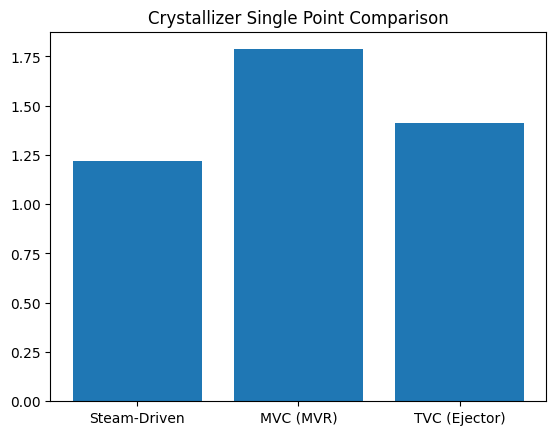

In [34]:
_ = (
    df_kpis[["LCOW ($/m³)"]]
    .sort_values("LCOW ($/m³)")
    .style.format({"LCOW ($/m³)": "{:.2f}"})
    .bar(subset=["LCOW ($/m³)"], color="#1f77b4")
)
# _
df_kpis[["LCOW ($/m³)"]]
fig, ax = plt.subplots()

ax.bar(df_kpis["LCOW ($/m³)"].index, df_kpis["LCOW ($/m³)"], color="#1f77b4")
ax.set_title("Crystallizer Single Point Comparison")

## Section F: Energy-price sweeps for technology screening

### WaterTAP sweeps **steam price (¢/kg)** and **electricity price (¢/kWh)** across ranges to compute **LCOW** for each flowsheet (Steam-Driven, MVC, TVC), revealing:
* **LCOW vs steam price**: how each option’s cost moves with steam.  
* **Least-cost technology map (steam vs electricity)**: which option is lowest-cost at a given price pair and the **switch lines** between them.  
* **LCOW surface heatmap**: sensitivity of minimum LCOW to concurrent steam and electricity price changes.  
Use these to quickly **screen technologies**, plan **energy contracts**, and understand **price-exposure risk**.

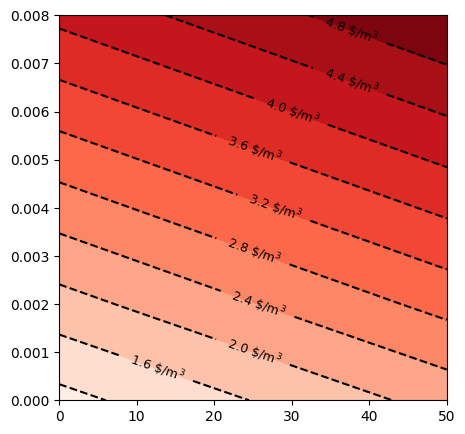

In [35]:
from parameter_sweep import LinearSample, parameter_sweep


def set_up_sensitivity(m, cryst_module):
    outputs = {}
    optimize_kwargs = {"tee": False}
    opt_function = cryst_module.solve
    outputs["LCOW"] = m.fs.costing.LCOW
    outputs["SEC"] = m.fs.costing.specific_energy_consumption
    return outputs, optimize_kwargs, opt_function


def run_cryst_sweep(cryst_module, nx=50, output_filename="live_cryst_sweep.csv"):
    solver = get_solver()
    m = cryst_module.build()
    cryst_module.set_operating_conditions(m)
    cryst_module.initialize_system(m, solver=solver)
    cryst_module.optimize_set_up(m)

    outputs, optimize_kwargs, opt_function = set_up_sensitivity(m, cryst_module)

    sweep_params = {}

    sweep_params["steam_cost"] = LinearSample(
        m.fs.costing.steam_cost, 0.00, 0.008, nx
    )
    
    sweep_params["electricity_cost"] = LinearSample(
        m.fs.costing.electricity_cost, 0.00, 0.5, nx
    )

    global_results = parameter_sweep(
        m,
        sweep_params,
        outputs,
        csv_results_file_name=output_filename,
        optimize_function=opt_function,
        optimize_kwargs=optimize_kwargs,
    )

    return global_results, sweep_params, m



fc_results, sweep_params, m = run_cryst_sweep(
    steam, nx=5, output_filename="FC_cryst_sweep-test.csv"
)
clear_output(wait=False)
df = pd.read_csv("FC_cryst_sweep-test.csv")
df["steam_cost"] = df["# steam_cost"] * 1000
df["electricity_cost"] = df["electricity_cost"] * 100
fig, ax = plot_contour(
    df,
    y="# steam_cost",
    x="electricity_cost",
    z="LCOW",
    approach="pivot",
    cmap="Reds",
)
# mvc_results, sweep_params, m_mvc = run_cryst_sweep(
#     mvc, output_filename="MVC_cryst_sweep2.csv"
# )
# clear_output(wait=False)
# tvc_results, sweep_params, m_tvc = run_cryst_sweep(
#     tvc, output_filename="TVC_cryst_sweep2.csv"
# )
# clear_output(wait=False)
# assert False
# --------------------------------------------------------------------------------


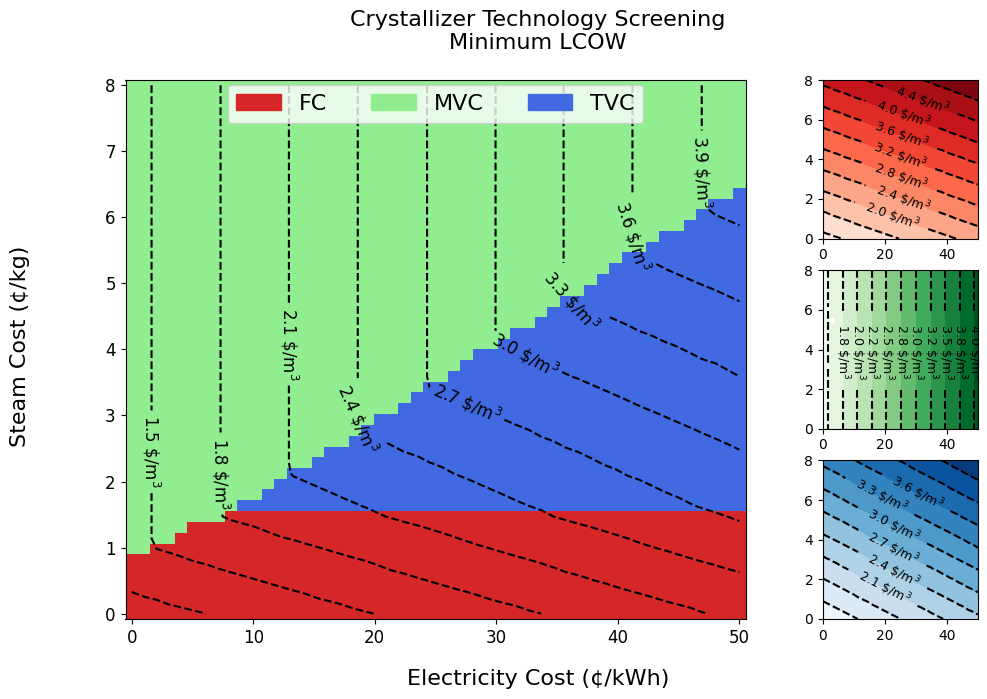

In [36]:

df1 = pd.read_csv("FC_cryst_sweep2.csv")
df1["steam_cost"] = df1["steam_cost"] * 1000
df1["electricity_cost"] = df1["electricity_cost"] * 100
df2 = pd.read_csv("MVC_cryst_sweep2.csv")
df2["steam_cost"] = df2["steam_cost"] * 1000
df2["electricity_cost"] = df2["electricity_cost"] * 100
df3 = pd.read_csv("TVC_cryst_sweep2.csv")
df3["steam_cost"] = df3["steam_cost"] * 1000
df3["electricity_cost"] = df3["electricity_cost"] * 100

fig, axs = plt.subplot_mosaic(
    [["combo", "fc"], ["combo", "mvc"], ["combo", "tvc"]],
    figsize=(11, 7),
    width_ratios=(4, 1),
    height_ratios=(2, 2, 2),
)
# --------------------------------------------------------------------------------
ax = axs["fc"]
plot_contour(
    df1,
    y="steam_cost",
    x="electricity_cost",
    z="LCOW",
    approach="pivot",
    cmap="Reds",
    fig=fig,
    ax=ax,
)

ax = axs["mvc"]
fig, ax = plot_contour(
    df2,
    y="steam_cost",
    x="electricity_cost",
    z="LCOW",
    approach="pivot",
    cmap="Greens",
    fig=fig,
    ax=ax,
)
# --------------------------------------------------------------------------------
ax = axs["tvc"]
fig, ax = plot_contour(
    df3,
    y="steam_cost",
    x="electricity_cost",
    z="LCOW",
    approach="pivot",
    cmap="Blues",
    fig=fig,
    ax=ax,
)
# --------------------------------------------------------------------------------
ax = axs["combo"]

plot_min_lcow(df1, df2, df3, fig, axs)

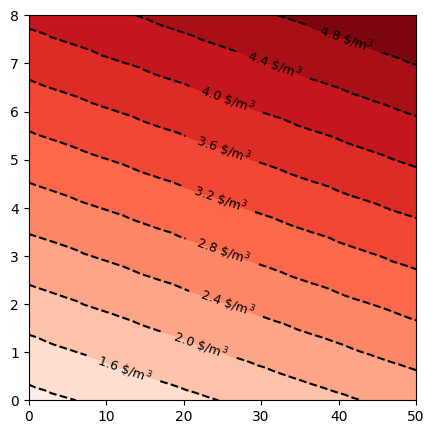

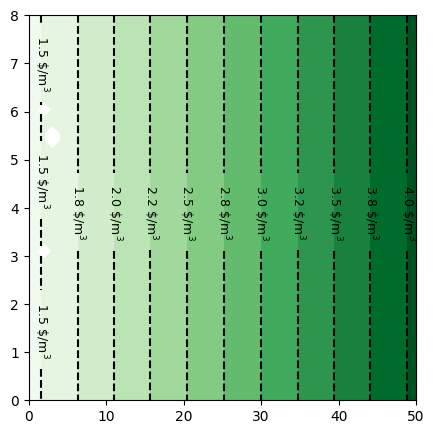

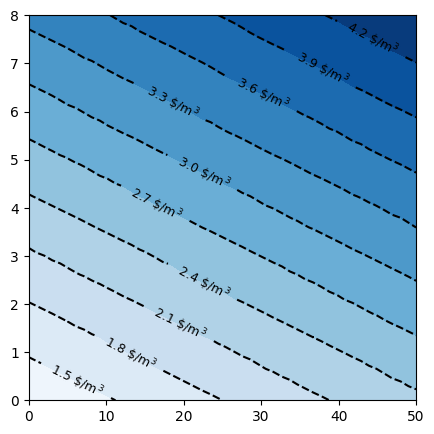

In [21]:

plot_contour(
    df1,
    y="steam_cost",
    x="electricity_cost",
    z="LCOW",
    approach="pivot",
    cmap="Reds",
    # fig=fig,
    # ax=ax,
)

fig, ax = plot_contour(
    df2,
    y="steam_cost",
    x="electricity_cost",
    z="LCOW",
    approach="pivot",
    cmap="Greens",
    # fig=fig,
    # ax=ax,
)
# ----------------
fig, ax = plot_contour(
    df3,
    y="steam_cost",
    x="electricity_cost",
    z="LCOW",
    approach="pivot",
    cmap="Blues",
    # fig=fig,
    # ax=ax,
)

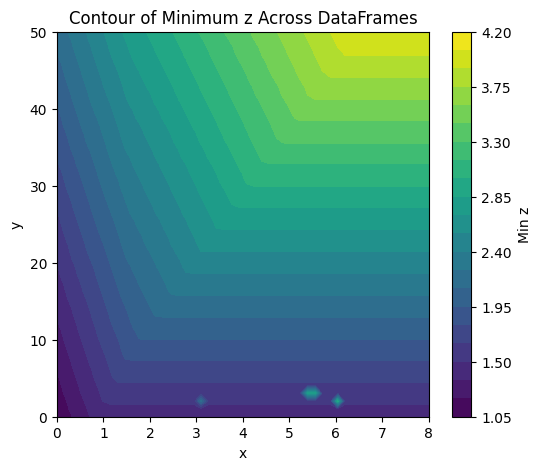

In [ ]:
# df_all = pd.concat([df1, df2, df3], axis=0)

# # Group by (x,y) and take the minimum z among the three
# df_min = df_all.groupby(["steam_cost", "electricity_cost"], as_index=False)[
#     "LCOW"
# ].min()

# # Reshape into grid for contour plotting
# X = df_min["steam_cost"].unique()
# Y = df_min["electricity_cost"].unique()
# X, Y = np.meshgrid(X, Y)

# # Pivot into 2D array of z values
# Z = df_min.pivot(index="electricity_cost", columns="steam_cost", values="LCOW").values

# # Make contour plot
# plt.figure(figsize=(6, 5))
# cp = plt.contourf(X, Y, Z, levels=20)
# plt.colorbar(cp, label="Min z")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.title("Contour of Minimum z Across DataFrames")
# plt.show()

In [ ]:

# capex = {"FC": {}, "MVC": {}, "TVC": {}}
# opex = {"FC": {}, "MVC": {}, "TVC": {}}
# comps = ["crystallizer", "heater", "mixer", "pump"]
# agg_flow = ["electricity", "steam"]
# for comp in comps:
#     # print(comp)
#     cb = m.find_component(f"fs.{comp}.costing")
#     capex["FC"][comp] = value(cb.capital_cost)
#     operating_cost = 0
#     operating_cost += value(cb.capital_cost) * 0.03
#     fixed_op = cb.find_component("fixed_operating_cost")
#     if fixed_op is not None:
#         operating_cost += value(cb.fixed_operating_cost)
#     var_op = cb.find_component("variable_operating_cost")
#     if var_op is not None:
#         operating_cost += value(cb.variable_operating_cost)
#     opex["FC"][comp] = operating_cost
# for agg in agg_flow:
#     if value(m.fs.costing.aggregate_flow_costs[agg]) < 1e-8:
#         print(agg)
#         continue
#     else:
#         opex["FC"][agg] = value(m.fs.costing.aggregate_flow_costs[agg])
# # operating_cost += value(m.fs.costing.aggregate_flow_costs["steam"])
# # capex["FC"][comp] = value(cb.capital_cost)
# print(sum(opex["FC"].values()), m.fs.costing.total_operating_cost())
# comps = ["crystallizer", "heater", "mixer", "compressor", "pump"]
# for comp in comps:
#     # print(comp)
#     cb = m_mvc.find_component(f"fs.{comp}.costing")
#     capex["MVC"][comp] = value(cb.capital_cost)
#     operating_cost = 0
#     operating_cost += value(cb.capital_cost) * 0.03
#     fixed_op = cb.find_component("fixed_operating_cost")
#     if fixed_op is not None:
#         operating_cost += value(cb.fixed_operating_cost)
#     var_op = cb.find_component("variable_operating_cost")
#     if var_op is not None:
#         operating_cost += value(cb.variable_operating_cost)
#     opex["MVC"][comp] = operating_cost
#     for agg in agg_flow:
#         if value(m.fs.costing.aggregate_flow_costs[agg]) < 1e-8:
#             continue
#         else:
#             opex["MVC"][agg] = value(m.fs.costing.aggregate_flow_costs[agg])
# comps = ["crystallizer", "heater", "mixer", "SteamEjector", "pump"]
# for comp in comps:
#     # print(comp)
#     cb = m_tvc.find_component(f"fs.{comp}.costing")
#     capex["TVC"][comp] = value(cb.capital_cost)
#     operating_cost = 0
#     operating_cost += value(cb.capital_cost) * 0.03
#     fixed_op = cb.find_component("fixed_operating_cost")
#     if fixed_op is not None:
#         operating_cost += value(cb.fixed_operating_cost)
#     var_op = cb.find_component("variable_operating_cost")
#     if var_op is not None:
#         operating_cost += value(cb.variable_operating_cost)
#     opex["TVC"][comp] = operating_cost
#     for agg in agg_flow:
#         if value(m.fs.costing.aggregate_flow_costs[agg]) < 1e-8:
#             print(agg, m.fs.costing.aggregate_flow_costs[agg]())
#             continue
#         else:
#             opex["TVC"][agg] = value(m.fs.costing.aggregate_flow_costs[agg])

# for d,t in zip([capex, opex], ["CAPEX", "OPEX"]):
#     all_subcats = sorted({sub for vals in d.values() for sub in vals})

#     groups = list(d.keys())
#     aligned_data = {
#         sub: [d[g].get(sub, 0) for g in groups]
#         for sub in all_subcats
#     }

#     bottom = [0] * len(groups)
#     for sub in all_subcats:
#         values = aligned_data[sub]
#         plt.bar(groups, values, bottom=bottom, label=sub)
#         bottom = [b + v for b, v in zip(bottom, values)]

#     # Formatting
#     plt.ylabel("Cost ($)")
#     plt.title(f"{t} Breakdown by Technology")
#     plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
#     plt.tight_layout()
#     plt.show()
#     opex

In [ ]:
# from IPython.display import Image, display
# from pathlib import Path

# for fn in (
#     "steam_cost_vs_lcow.png",
#     "steam-electricity-heat-map.png",
#     "least-cost-map.png",
#     "/mnt/data/steam_cost_vs_lcow.png",
#     "/mnt/data/steam-electricity-heat-map.png",
#     "/mnt/data/least-cost-map.png",
# ):
#     if Path(fn).exists():
#         display(Image(fn, width=900))

# --- How to reproduce (commented)
# from sweep_analysis_and_plots import main
# main()
#
# # Or run individual sweeps (time-consuming):
# from sweep_electricity import run_electricity_price_sweep      # MVC electricity sweep
# from sweep_steam import run_steam_cost_sweep                   # TVC steam sweep
# from sweep_steam_no_heat_recovery import run_steam_cost_sweep  # FC steam sweep
# run_electricity_price_sweep(nx=200, output_filename="electricity_price_sweep_elec.csv")
# run_steam_cost_sweep(nx=200, output_filename="steam_price_sweep_hr.csv")
# run_steam_cost_sweep(nx=200, output_filename="steam_price_sweep_nhr.csv")
# --------------------------------------------------------------------------------